https://nbviewer.jupyter.org/gist/antimon2/dd23b1e62d5fcd08d91fd420d7ba996d/Mandelbrot.mt.cu.jl.ipynb

typeof(c) = Matrix{ComplexF64}
  0.170879 seconds (285.29 k allocations: 15.919 MiB, 4.31% gc time, 36.16% compilation time)
  0.109360 seconds (4 allocations: 512.078 KiB)
typeof(m) = Matrix{Int64}


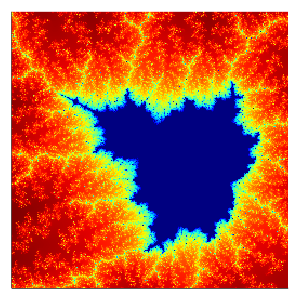

In [1]:
using BenchmarkTools
using Plots
gr(fmt=:png)

plotmandelbrot(m) = heatmap(m; c=reverse(cgrad(:jet1)), 
    size=(300, 300), colorbar=false, ticks=false, frame=false)

function mandelbrot(c; maxiters=2^10, threshold_abs2=2^10)
    z = zero(c)
    for i in 1:maxiters
        z = z * z + c
        abs2(z) ≥ threshold_abs2 && return i
    end
    maxiters + 1
end

n = 2^8
x = range(-0.714689, -0.714679; length=n)
y = range( 0.299872,  0.299882; length=n)
c = complex.(x', y)

@show typeof(c)
@time m = mandelbrot.(c)
@time m = mandelbrot.(c)
@show typeof(m)
plotmandelbrot(m)

typeof(c32) = Matrix{ComplexF32}
  0.161528 seconds (267.75 k allocations: 14.932 MiB, 31.11% compilation time)
  0.110682 seconds (4 allocations: 512.078 KiB)
typeof(m32) = Matrix{Int64}


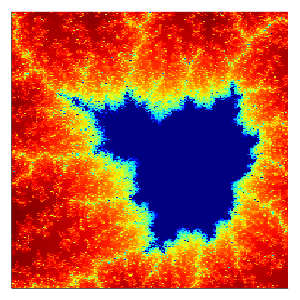

In [2]:
x32 = range(-0.714689f0, -0.714679f0; length=n)
y32 = range( 0.299872f0,  0.299882f0; length=n)
c32 = complex.(x32', y32)

@show typeof(c32)
@time m32 = mandelbrot.(c32)
@time m32 = mandelbrot.(c32)
@show typeof(m32)
plotmandelbrot(m32)

typeof(c_cuda) = CuArray{ComplexF32, 2}
 10.137558 seconds (27.53 M allocations: 1.453 GiB, 4.00% gc time, 0.08% compilation time)
  0.000821 seconds (692 allocations: 523.328 KiB)
typeof(mandelbrot.(c_cuda)) = CuArray{Int64, 2}
typeof(collect(mandelbrot.(c_cuda))) = Matrix{Int64}


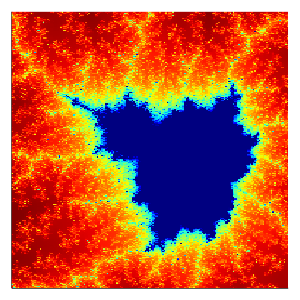

In [3]:
using CUDA
c_cuda = cu(c32)

@show typeof(c_cuda)
@time m_cuda = collect(mandelbrot.(c_cuda))
@time m_cuda = collect(mandelbrot.(c_cuda))
@show typeof(mandelbrot.(c_cuda))
@show typeof(collect(mandelbrot.(c_cuda)))
plotmandelbrot(m_cuda)

Threads.nthreads() = 12
  0.080125 seconds (223.05 k allocations: 12.639 MiB, 80.35% compilation time)
  0.014523 seconds (77 allocations: 519.734 KiB)


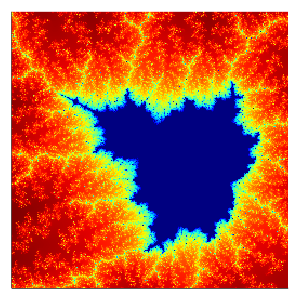

In [4]:
function mandelbrot_threads(c)
    m = similar(c, typeof(mandelbrot(c[end])))
    Threads.@threads for i in keys(c)
        m[i] = mandelbrot(c[i])
    end
    m
end

@show Threads.nthreads()
@time m_th = mandelbrot_threads(c)
@time m_th = mandelbrot_threads(c)
plotmandelbrot(m_th)

In [5]:
@benchmark mandelbrot.($c) # CPU Float64

BenchmarkTools.Trial: 46 samples with 1 evaluation.
 Range (min … max):  108.412 ms … 111.526 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     109.322 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   109.572 ms ± 744.611 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▁  ▄ ▁ ▁▁▄ ▁█▁    ▄              ▄▁         ▁             
  ▆▁▆▁▁█▁▆█▁█▆███▁███▆▁▆▁█▁▁▁▁▆▁▁▁▁▆▆▆▁▁██▁▁▆▆▁▁▆▁▁█▁▁▁▁▁▁▁▁▁▁▆ ▁
  108 ms           Histogram: frequency by time          112 ms <

 Memory estimate: 512.05 KiB, allocs estimate: 2.

In [6]:
@benchmark mandelbrot.($c32) # CPU Float32

BenchmarkTools.Trial: 46 samples with 1 evaluation.
 Range (min … max):  107.819 ms … 111.844 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     109.314 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   109.605 ms ± 939.714 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                ▁ █▁▁▁▁ ▄     ▄   ▁          ▁                   
  ▆▁▁▁▁▆▁▁▁▁▆▆▆▆█▁█████▆█▆▁▁▆▆█▁▁▆█▆▆▁▁▆▁▁▆▆▁█▁▁▆▁▆▁▁▁▆▆▁▁▁▁▁▆▆ ▁
  108 ms           Histogram: frequency by time          112 ms <

 Memory estimate: 512.05 KiB, allocs estimate: 2.

In [7]:
@benchmark collect(mandelbrot.($c_cuda)) # GPU Float32 (GPU → GPU)

BenchmarkTools.Trial: 8895 samples with 1 evaluation.
 Range (min … max):  440.300 μs …   5.770 ms  ┊ GC (min … max): 0.00% … 88.72%
 Time  (median):     529.100 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   558.376 μs ± 322.892 μs  ┊ GC (mean ± σ):  5.03% ±  7.69%

               ▃█▂                                               
  ▁▆█▄▃▂▂▂▂▁▁▁▂███▇▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  440 μs           Histogram: frequency by time          809 μs <

 Memory estimate: 515.86 KiB, allocs estimate: 218.

In [8]:
@benchmark collect(mandelbrot.(cu($c))) # GPU Float32 (CPU → GPU → GPU → CPU)

BenchmarkTools.Trial: 6265 samples with 1 evaluation.
 Range (min … max):  603.900 μs …   5.527 ms  ┊ GC (min … max): 0.00% … 82.88%
 Time  (median):     776.100 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   793.723 μs ± 393.021 μs  ┊ GC (mean ± σ):  5.75% ±  9.59%

  █   ▄                                                          
  █▆▄▇█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂ ▂
  604 μs           Histogram: frequency by time         3.36 ms <

 Memory estimate: 1.00 MiB, allocs estimate: 182.

In [ ]:
@show Threads.nthreads()
@benchmark mandelbrot_threads($c) # CPU Float64 multi-threaded version with nthreads = 12